# Clasificador perros y gatos

- Añadimos red preentrenada mobilenet_v2 

# Load Data

In [7]:
import pandas as pd
import numpy as np
import PIL
import os
import matplotlib.pyplot as plt
import warnings
import tqdm # Track loading time
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [8]:
ROOT_PATH = Path().resolve() / "data" / "petimages"

input_path = []
label = []

# Recorremos carpetas (Dog y cat)
for folder in os.listdir(ROOT_PATH):
    # Recorremos fotos
    for fichero in tqdm.tqdm(os.listdir(os.path.join(ROOT_PATH, folder))):
        if(folder=='Cat'):
            label.append(0)
        else:
            label.append(1)

        input_path.append(os.path.join(ROOT_PATH, folder, fichero))

ID_TEST = 22000 # 1 - 25002
NOMBRE_ANIMAL = ''     

if(label[ID_TEST] == 0): NOMBRE_ANIMAL = 'Gato' 
else: NOMBRE_ANIMAL = 'Perro' 

#print(input_path[ID_TEST], NOMBRE_ANIMAL)
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label

# label debe ser tipo string para modelo
df['label'] = df['label'].astype('str')

#shuffle 
df = df.sample(frac=1).reset_index(drop=True)

imagenes_invalidas = []

for image_path in df['images']:
    try:
        img = PIL.Image.open(image_path)
        img.verify()  # para asegurar que la imagen no esté corrupta
    except Exception:
        imagenes_invalidas.append(image_path)

def borraImgInvalidas():    
    for fichero in imagenes_invalidas:
        try:
            os.remove(fichero)
            print(f"Eliminado: {fichero}")
        except Exception as e:
            print(f"No se pudo eliminar {fichero}: {e}")

borraImgInvalidas()


100%|██████████| 12499/12499 [00:00<00:00, 595179.56it/s]


In [9]:
train_val, test = train_test_split(df, test_size=0.04, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

print(f"Train: {len(train)}")
print(f"Validation: {len(val)}")
print(f"Test: {len(test)}")

Train: 21598
Validation: 2400
Test: 1000


In [10]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_iterator = train_gen.flow_from_dataframe(
    train, x_col='images', y_col='label',
    target_size=(224, 224), batch_size=64,
    class_mode='binary'
)

val_iterator = val_test_gen.flow_from_dataframe(
    val, x_col='images', y_col='label',
    target_size=(224, 224), batch_size=64,
    class_mode='binary'
)

test_iterator = val_test_gen.flow_from_dataframe(
    test, x_col='images', y_col='label',
    target_size=(224, 224), batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 21598 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Congelar todas las capas convolucionales
for layer in base_model.layers:
    layer.trainable = False

# Añadir cabeza personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.summary()

# Entrenamiento
history = model.fit(
    train_iterator,
    epochs=10,
    validation_data=val_iterator
)

# Evaluación final
loss, acc = model.evaluate(test_iterator)
print(f"\n✅ Accuracy en test: {acc:.4f} ({int(acc * len(test))}/{len(test)})")

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 272s 798ms/step - accuracy: 0.9478 - loss: 0.1403 - val_accuracy: 0.9833 - val_loss: 0.0409
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 268s 794ms/step - accuracy: 0.9675 - loss: 0.0841 - val_accuracy: 0.9850 - val_loss: 0.0348
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 271s 801ms/step - accuracy: 0.9674 - loss: 0.0821 - val_accuracy: 0.9892 - val_loss: 0.0331
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 270s 797ms/step - accuracy: 0.9725 - loss: 0.0696 - val_accuracy: 0.9804 - val_loss: 0.0409
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 271s 803ms/step - accuracy: 0.9715 - loss: 0.0681 - val_accuracy: 0.9825 - val_loss: 0.0406
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 268s 791ms/step - accuracy: 0.9736 - loss: 0.0662 - val_accuracy: 0.9900 - val_loss: 0.0294
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 267s 790ms/step - accuracy: 0.9761 - loss: 0.0616 - val_accuracy: 0.9817 - val_loss: 0.0377
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 267s 789ms/step - accuracy: 0.9742 -

In [12]:
# # Guardamos modelo
# dirname ='C:\SourceCode\Machine_learning\Clasificador Perros-gatos'
# filename = os.path.join(dirname, 'modelo_predict.h5')
# model.save(filename)  

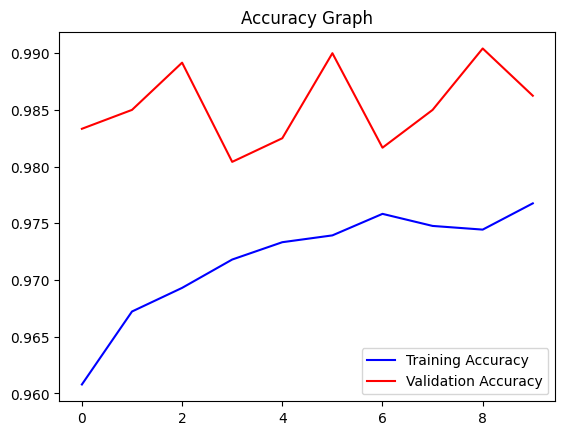

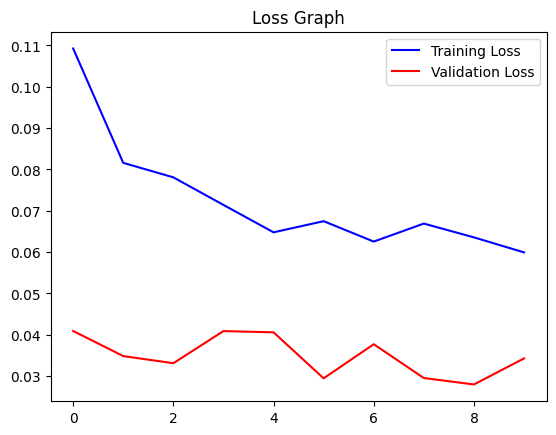

<Figure size 640x480 with 0 Axes>

In [13]:
# Revisamos modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

plt.show()

In [14]:
# Evaluar modelo en el conjunto de test
loss, accuracy = model.evaluate(test_iterator)
print(f"\n✅ Accuracy en test: {accuracy:.4f} ({int(accuracy * len(test))}/{len(test)})")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step - accuracy: 0.9786 - loss: 0.0528

✅ Accuracy en test: 0.9840 (984/1000)
